## Background

Somos un conglomerado de supermercados, MWC Markets, y disponemos de los datos históricos de nuestros centros (TYPE_A: Bon Digital Talent, TYPE_B: MWC Supermercados, TYPE_C: MercaBDT).

En estos datos se pueden ver las siguientes variables:

Demanda semanal:

- id: ID único de la instancia
- week: Número de la semana
- checkout_price: Precio de venta final del producto (después de aplicarles descuentos, cargas de transporte, etc.)
- base_price: Precio base del producto
- emailer_for_promotion: Campaña de emails enviada para promocionar el producto (1: Sí se ha enviado ; 0: No se ha enviado)
- homepage_featured: Producto promocionado en la página web
- num_orders: Número de órdenes de cada producto
- center_id: ID del centro 
- meal_id: ID del producto

Información del centro

- center_id: ID del centro
- city_code: Código para una ciudad en particular
- region_code: Código para una región en particular
- center_type: Tipo de Supermercado
- op_area: Area de operaciones y tamaño de supermercado (en km^2)


Información del producto:

- meal_id: ID del producto
- category: Tipo de producto (beverages/snacks/soups, etc.)
- cuisine: Tipo de cocina del producto (Indian/Italian, etc.)


## Goals 🎯

Hasta ahora todas las operaciones y gestión de datos lo hemos hecho de maneras rudimentarias, pero
nuestra intención es digitalizar todos los procesos. Es por eso que con estos datos puedes abarcar
alguno de estos problemas:
    
1. Diseñar una plataforma para el equipo logístico para poder tener información de nuestros centros y predecir el número de pedidos que vamos a necesitar en nuestros supermercados.


2. Diseñar una plataforma para nuestros clientes para que puedan comprar los productos por Internet y les lleven la compra a casa (teniendo en cuenta el stock y las limitaciones operativas (Los clientes sólo pueden pedir comida desde los centros que están en su ciudad de manera gratuita si superan un mínimo de u.m., sinó se cobran gastos por envío. También tienen que poder comprar a un supermercado de otra ciudad que esté en la misma región, pero se les cobra sí o sí por envío). En la plataforma se tiene que poder comprar de los tres tipos de centros.


3. Diseñar una plataforma para nuestro equipo de estrategia y marketing para que puedan ver cuáles son los productos más exitosos, los centros de dónde sacan más rendimiento y cuáles son las mejores estrategias para conseguir maximizar el número de pedidos.

## Key Concepts / Discussion / Pitching 📣

| PROBLEMA          | REQUISITOS DE CADA PLATAFORMA                              |
|-------------------|------------------------------------------------------------|
| para Logística    | - Tener acceso al stock de cada centro                     |
|                   | - Modelo predictivo pedidos para gestionar stocks          |
|                   |                                                            |
| para Clientes     | - Gestionar pedidos en cualquier centro y actualizar stock |
|                   | - Aplicar descuentos , tarifas de envio                    |
|                   |                                                            |
| para BI/marketing | - Consultar productos mas exitosos                         |
|                   | - Ver rendimiento de los centros                           |
|                   | - Estrategias para maximizar pedidos                       |

## Imports 🗃

In [1]:
# Yolo!
import warnings
warnings.filterwarnings('ignore')

# Scientific and Data Manipulation Libraries :
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
from scipy.stats import kstest 
from pprint import pprint


# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import ListedColormap
import seaborn as sb
import ppscore as pps

# ML Pre-processing
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.preprocessing import PowerTransformer, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import roc_curve, auc, f1_score  
from xgboost.sklearn import XGBRegressor

# Other Settings
%matplotlib inline
sb.set()

## Methods 🛠

In [2]:
# methods to go by
def check_distribution(df):
    '''Returns a Multiplot Histogram for each variable in input df '''
    # Inputs
    df = pd.DataFrame(df)
    variables = df.columns
    n_rows = 8
    n_cols = 4
    
    #Plot
    sb.set(font_scale=1.2) 
    fig=plt.figure(figsize=(15,7))
    fig.patch.set_facecolor('slategrey')
    fig.suptitle('FEATURE DISTRIBUTION')
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=25, ax=ax)
        ax.set_title(var_name, size=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    fig.tight_layout()
    plt.show()
    plt.close('all')

    
def outliers(feature):
    '''Prints an outlier resume about one feature (ex: "df[AnyFeature]")'''    
    
    # calculate interquartile range
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q75 - q25
    print(f'{feature.name.upper()}')
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    # identify outliers
    outliers = [x for x in feature if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # show outliers/non-outliers and percentage
    non_outliers = [x for x in feature if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(non_outliers))
    proportion = len(outliers)/len(non_outliers)*100
    print(f'Outlier Percentage: {proportion:.2f} %\n')
    
    
    
def feature_plots(df,feature):
    '''plots input feature and it's relation with other variables in list below'''
    feature_list = ['num_orders', 'emailer_for_promotion', 'homepage_featured','week', 'net_bennefit']
    # figure setting
    fig = plt.figure(figsize=(16,9))
    
    for i,feat in enumerate(feature_list,start=1):
        
        if feat == str(feature):
            # basic rate plot
            plt.subplot(2, 3, i)
            plt.grid(color='k', linestyle='dotted', linewidth=0.5, axis='x')
            selection = df[str(feature)].value_counts(normalize=True).mul(100)
            ax = selection.plot(kind ='barh', color=['indianred', 'lightseagreen'],
                                alpha=0.5, edgecolor='purple')
            ax.xaxis.set_major_formatter(mtick.PercentFormatter())
            plt.xlabel('rate')
            plt.xticks(rotation=0)
            plt.title(f'{feature} Rate Distribution')
            
        else:
            # Combined with other features
            plt.subplot(2, 3, i)
            plt.grid(color='black', linestyle='--', linewidth=0.5)
            ax = sb.countplot(data=df, x=feature, palette='viridis_r', alpha=0.5 ,hue=feat)
            plt.xlabel('')
            plt.legend(loc='upper right')
            plt.title(f'Combined with {feat}')
    plt.suptitle(f'{feature.upper()} Feature Comparative', fontsize=18)
    plt.tight_layout()
    plt.show()
    plt.close('all')
    
    
def select_features(X_train, y_train, X_test):
    # Select all features
    fs = SelectKBest(score_func=f_classif, k='all' )
    
    # Learn relationship from training data
    fs.fit(X_train, y_train)
   
    return fs

def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.4f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

            
def check_variance_homogeneity(group1, group2):
    test_stat_var, p_value_var= stats.levene(group1,group2)
    print("p value:%.4f" % p_value_var)
    if p_value_var <0.05:
        print("Reject null hypothesis >> The variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis >> The variances of the samples are same.")

## The Data 💾

In [3]:
# first checks
df1 = pd.read_csv(r"C:\Users\motxi\Documents\HACKATHONS\NUWE\Jump2digital\weekly_demand.csv",delimiter=',')
print('WEEKLY DEMAND')
display(df1.info())
display(df1.describe())
display(df1.head())


# first checks
df2 = pd.read_csv(r"C:\Users\motxi\Documents\HACKATHONS\NUWE\Jump2digital\center_info.csv",delimiter=',')
print('CENTER INFO')
display(df2.info())
display(df2.describe())
display(df2.head())

# first checks
df3 = pd.read_csv(r"C:\Users\motxi\Documents\HACKATHONS\NUWE\Jump2digital\meal_info.csv",delimiter=',')
print('MEAL_INFO')
display(df3.info())
display(df3.describe())
display(df3.head())


df = pd.merge(df1, df2, left_on='center_id', right_on='center_id', how='left').drop('center_id', axis=1)
df = pd.merge(df, df3, left_on='meal_id', right_on='meal_id', how='left').drop('meal_id', axis=1)
df.head()

WEEKLY DEMAND
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


None

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


CENTER INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


None

,center_id,city_code,region_code,op_area
count,77.000000,77.000000,77.000000,77.000000
mean,83.142857,600.662338,56.493506,3.985714
std,46.090219,66.720274,18.126473,1.106406
min,10.000000,456.000000,23.000000,0.900000
25%,50.000000,553.000000,34.000000,3.500000
50%,77.000000,596.000000,56.000000,3.900000
75%,110.000000,651.000000,77.000000,4.400000
max,186.000000,713.000000,93.000000,7.000000


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


MEAL_INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


None

,meal_id
count,51.000000
mean,2013.921569
std,553.633555
min,1062.000000
25%,1550.500000
50%,1971.000000
75%,2516.500000
max,2956.000000


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [4]:
dups = df.duplicated()
print(f'Is there any duplicated rows?   {dups.any()}')

print('\nNull values?')
df.isna().sum()


samp = pd.DataFrame(df.sample(n=1000))
print(samp.head())
samp.to_json(r'C:\Users\motxi\Documents\HACKATHONS\NUWE\Air Quality Classification\dimitri.json')

Is there any duplicated rows?   False

Null values?
             id  week  checkout_price  base_price  emailer_for_promotion  \
403176  1027755   129          290.03      291.03                      0   
378398  1444508   122          226.01      292.03                      0   
327377  1325589   106          337.56      338.56                      0   
401747  1090648   129          427.80      427.80                      0   
363116  1469534   117          195.00      255.14                      1   

        homepage_featured  num_orders  city_code  region_code center_type  \
403176                  0          68        614           85      TYPE_A   
378398                  0         243        576           34      TYPE_B   
327377                  0         189        647           56      TYPE_A   
401747                  0          94        615           34      TYPE_B   
363116                  0         123        658           34      TYPE_B   

        op_area      categor

# EDA 

lets's get the most important variables for the first project, this is a regression model  to predict sells and consequently predict stocks needed

<AxesSubplot:ylabel='Frequency'>

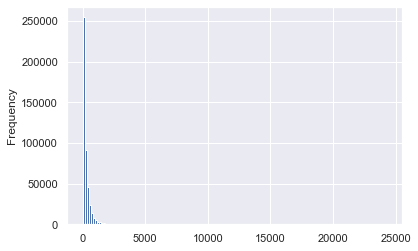

In [5]:
df['num_orders'].plot(kind='hist', bins=150)

In [6]:
# first we'll create some columns that we need: 
df['net_bennefit'] = df['checkout_price'] - df['base_price']
df.loc[df['net_bennefit'] <= 0, 'net_bennefit'] = int(0)
df.loc[df['net_bennefit'] > 0, 'net_bennefit'] = int(1)
df.rename(columns={'num_orders':'target'})


df.head()
df.describe()

,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area,net_bennefit
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590,0.254302
std,1.443548e+05,41.524956,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686,0.435469
min,1.000000e+06,1.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000,0.000000
25%,1.124999e+06,39.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000,0.000000
50%,1.250184e+06,76.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000,0.000000
75%,1.375140e+06,111.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000,1.000000
max,1.499999e+06,145.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000,1.000000


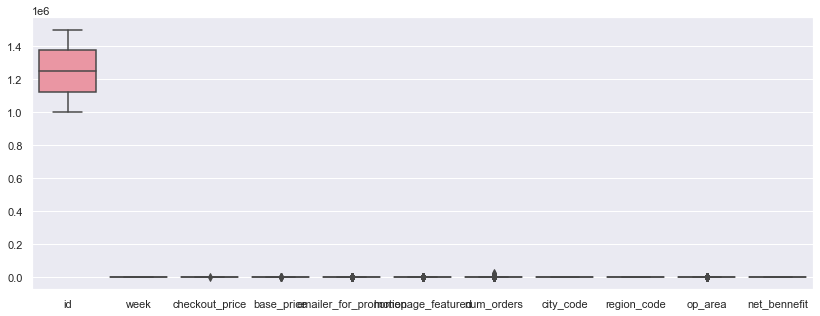

In [7]:
# all boxplots & outliers
plt.figure(figsize=(14,5))
sb.boxplot(data=df)
plt.show()
plt.close()

### Dependent variable  🎯

This is the number of orders, since we want to predict demand in advance

## Correlation

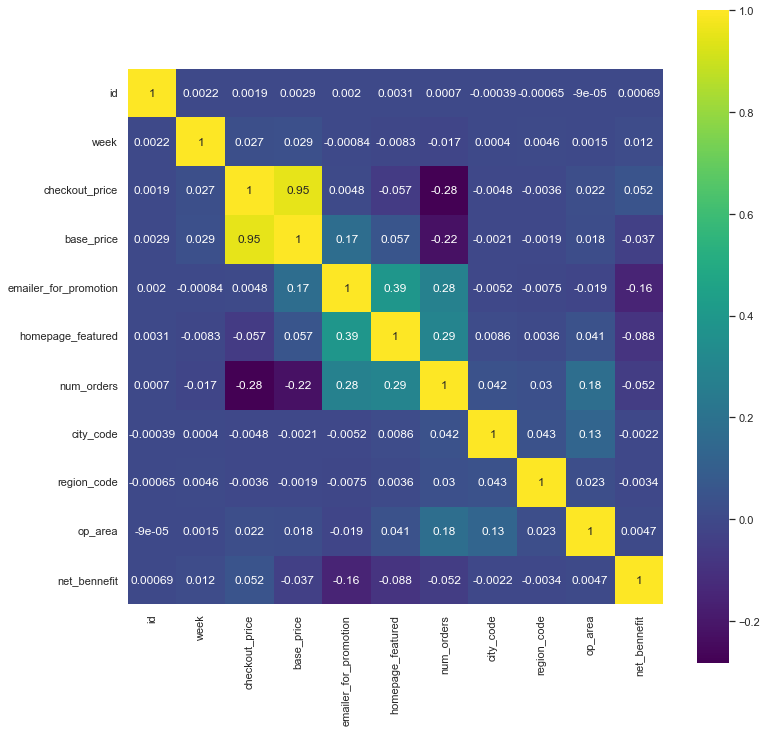

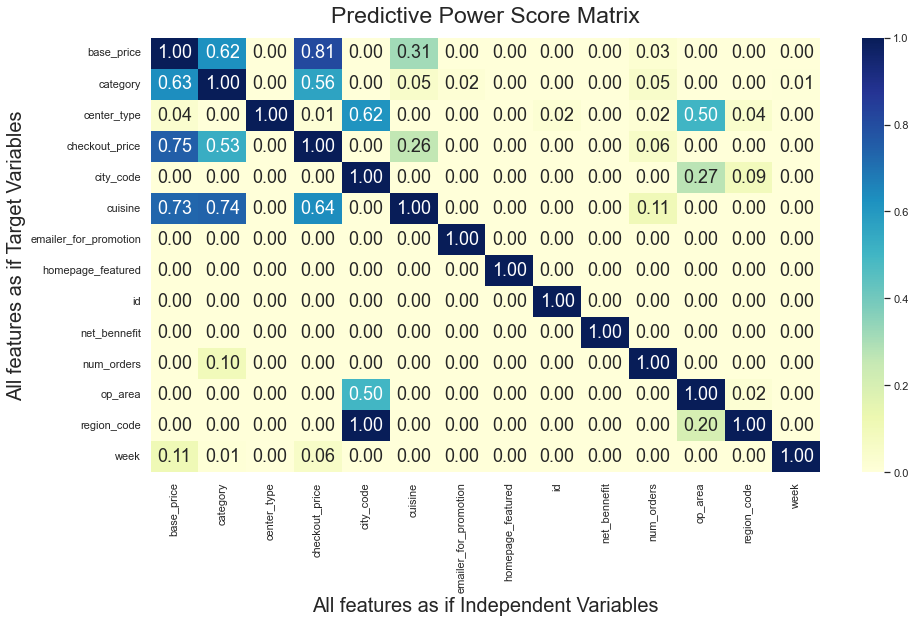

In [8]:
df_corr = df.corr()
plt.figure(figsize=(12,12))
sb.heatmap(data=df_corr, cmap='viridis', annot=True, square=True)


# plot PPS
plt.figure(figsize=(15,8))
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sb.heatmap(data=matrix_df, 
           vmin=0, 
           vmax=1,
           fmt=".2f",
           annot_kws={"size":18},
           cmap="YlGnBu",
           linewidths=0,
           annot=True
          )
plt.title("Predictive Power Score Matrix", fontsize=23, y=1.02)
plt.xlabel('All features as if Independent Variables', fontsize=20)
plt.ylabel('All features as if Target Variables', fontsize=20)
plt.show()

In [9]:
pd.get_dummies(df, columns=['center_type', 'cuisine'])
df.drop(columns=['category', 'center_type', 'cuisine', 'base_price', 'checkout_price', 'city_code', 'cuisine', 'op_area', 'region_code'], axis=1, inplace=True)

# do train/test split and check shapes
X = df.drop(columns='num_orders')
y = df[['num_orders']]

# train/test splits
X_train, X_test,y_train, y_test = (train_test_split(X,y, test_size=0.20, random_state=1))
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)



X_train shape: (365238, 5)
y_train shape: (365238, 1)
X_test shape: (91310, 5)
y_test shape: (91310, 1)


In [10]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

## Spot checking Algorithms

In [14]:
# set kfold cv and general parameters 
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
num_trees = 150

d = {}


# Create regressor object
model = LinearRegression()
results_lr = cross_val_score(model, X_train, y_train, cv=kfold)
d['Linear Regression'] = results_lr

# Create regressor object
model = GradientBoostingRegressor()
results_gb = cross_val_score(model, X_train, y_train, cv=kfold)
d['Gradient Boosting Regression'] = results_gb

# Create regressor object
model = SGDRegressor()
SGD = cross_val_score(model, X_train, y_train, cv=kfold)
d['SGD Regression'] = SGD

# Create regressor object
model = RandomForestRegressor()
results_rf = cross_val_score(model, X_train, y_train, cv=kfold)
d['rf Regression'] = results_rf


# convert dict to dataframe
scores_df = pd.DataFrame(d).reset_index(drop=True)

scores_df.describe()

,Linear Regression,Gradient Boosting Regression,SGD Regression,rf Regression
count,3.000000,3.000000,3.000000,3.000000
mean,0.116813,0.150700,0.114749,-0.030098
std,0.002184,0.001444,0.002428,0.007607
min,0.114304,0.149354,0.112213,-0.038641
25%,0.116076,0.149938,0.113598,-0.033118
50%,0.117848,0.150522,0.114982,-0.027595
75%,0.118068,0.151373,0.116017,-0.025827
max,0.118288,0.152225,0.117053,-0.024058
